# Multinomial Naïve Bayes

This Notebook will have you working and experimenting with the Multinomial Naïve Bayes classifier. Initially, you will transform the given data in csv file to count matrix, then calculate the priors. Use those priors to compute likelyhoods according to Multinomial Naive Bayes and then classify the test data. Please note that use of `sklearn` implementations is only for the final question of the assignment, for other doubts regarding libraries you can reach out to the TAs.

The dataset is about `Spam SMS`. There is 1 attribute that is the `message`, and the class label which could be `spam` or `ham`. The data is present in `spam.csv`. It contains about 5-6000 samples.
For your convinience the data is already pre-processed and loaded, but I suggest you to just take a look at the code for your own knowledge, and parts vectorization is left up to you which could be easily done.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading text-based data using pandas

In [2]:
# read file into pandas using a relative path

df = pd.read_csv("spam.csv", encoding='latin-1')
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Pre-processing

- Our main issue with our data is that it is all in text format (strings). The classification algorithms that we usally use need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the bag-of-words approach, where each unique word in a text will be represented by one number.

- As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

In [3]:
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\use\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df['message'] = df.message.apply(text_process)
df.head()

,label,message
0,ham,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar Joking wif oni
2,spam,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,dun say early hor c already say
4,ham,Nah think goes usf lives around though


In [5]:
df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,message
0,0,Go jurong point crazy Available bugis n great ...
1,0,Ok lar Joking wif oni
2,1,Free entry wkly comp win FA Cup final tkts 21s...
3,0,dun say early hor c already say
4,0,Nah think goes usf lives around though


## Splitting the data

In [6]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

X = df.message
y = df.label

print(f'X: {X.shape}')
print(f'y: {y.shape}')
print()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print()

print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')
print()

X: (5572,)
y: (5572,)

X_train: (4179,)
y_train: (4179,)

X_test: (1393,)
y_test: (1393,)



## Helper code / Example code for Representing text as Numerical data using Sci-kit learn

📌 From the scikit-learn documentation:
- Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.
- We will use CountVectorizer to "convert text into a matrix of token counts":

In [7]:
# example text for model training (SMS messages)
simple_train = ['call you tonight', 'Call me a cab', 'Please call me... PLEASE!']

In [8]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
simple_train = vect.fit_transform(simple_train)

vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [9]:
vect.get_feature_names_out()

array(['cab', 'call', 'me', 'please', 'tonight', 'you'], dtype=object)

In [10]:
# convert sparse matrix to a dense matrix
simple_train.toarray()

array([[0, 1, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 2, 0, 0]], dtype=int64)

In this scheme, features and samples are defined as follows:

- Each individual token occurrence frequency (normalized or not) is treated as a feature.
- The vector of all the token frequencies for a given document is considered a multivariate sample.

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

In [11]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_train.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,0,0,1,1
1,1,1,1,0,0,0
2,0,1,1,2,0,0


### Transform Testing data into a document-term matrix (using existing / training vocabulary)

- You are supposed to use the training vocabolary to make the count matrix for test data

In [12]:
simple_test = ["please don't call me"]

In [13]:
simple_test_dtm = vect.transform(simple_test)
simple_test_dtm.toarray()

array([[0, 1, 1, 1, 0, 0]], dtype=int64)

In [14]:
# examine the vocabulary and document-term matrix together
pd.DataFrame(simple_test_dtm.toarray(), columns=vect.get_feature_names_out())

,cab,call,me,please,tonight,you
0,0,1,1,1,0,0


## Multinomial Naive Bayes Implementation

- This task implements Mutlinomial Naive Bayes from scratch, we have used numpy to vectorize your code and matplotlib  to show your analysis.
- Below some information has given from the documentation about Multinomial Naive Bayes, this will give you some idea about using *Smoothing Priors*.
- There is a sub-question for experimenting with $\alpha > 0$, you don't have to implement it separetely, try to incomporate it in same Model Class / Function.

📌 From the scikit-learn documentation:

- Multinomial Naive Bayes implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

- The distribution $\theta_y = (\theta_{y1}, \theta_{y2}, \dots, \theta_{yn})$ is parametrized by vectors for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P(x_i|y)$ of feature appearing in a sample belonging to class.

- The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$$
\hat{\theta}_{yi} = \frac{N_{yi} + \alpha}{N_{y} + \alpha n}
$$

 where $N_{yi} = \sum_{x \in T}{x_i}$ is the number of times feature $i $ appears in a sample of class in the training set $T$, and $N_{y} = \sum^{n}_{i=1}{N_{yi}}$ is the total count of all features for class $y$.

- The smoothing priors $\alpha \gt 0$ accounts for features not present in the learning samples and **prevents zero probabilities** in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha \lt 1$ is called Lidstone smoothing.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score


## Vectorizing Training Sample

- Use the Helper code above to vectorize for training samples
- Don't overthink it, its very easy to do

In [ ]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)

vect.get_feature_names_out()

array(['008704050406', '0121', '01223585236', ..., 'ûïharry', 'ûò',
       'ûówell'], dtype=object)

In [17]:
X_train = X_train.toarray()
X_train.shape

(4179, 7996)

In [18]:
pd.DataFrame(X_train, columns=vect.get_feature_names_out())

,008704050406,0121,01223585236,01223585334,0125698789,020603,02070836089,02072069400,02073162414,02085076972,...,åòits,åômorrow,åôrents,ìll,ìï,ìïll,ûªve,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate Priors and Estimate Model's performance on Training Sample

- Calculate priors based on Training Sample using your NB implementation
- Evaluate your model's performance on Training Data ($\alpha = 0$)

In [ ]:
d=[[0 for i in range(len(vect.vocabulary_))] for j in range(2)]

feature_names = vect.get_feature_names_out()

for i in range(len(X_train)):
    if y_train.iloc[i]==0:
        arr = np.where(X_train[i]!=0)[0]
        for j in arr:
            d[0][j]+=1
    else:
        arr = np.where(X_train[i]!=0)[0]
        for j in arr:
            d[1][j]+=1

counts={}
counts[0]=len(np.where(y_train==0)[0])
counts[1]=len(np.where(y_train==1)[0])

In [20]:
alpha=0
Y_pred=[]
for i in range(len(X_train)):
    arr= np.where(X_train[i]!=0)[0]
    prob1 = counts[0]/(counts[0]+counts[1])
    prob2 = counts[1]/(counts[0]+counts[1])
    for j in arr:
        prob1*= (d[0][j]+alpha)/(counts[0] + alpha*X_train.shape[1])
        prob2*= (d[1][j]+alpha)/(counts[1] + alpha*X_train.shape[1])
    if prob1>prob2:
        Y_pred.append(0)
    else:
        Y_pred.append(1)
    #print(prob1,prob2)
Y_pred = np.asarray(Y_pred)
Y_pred.shape

(4179,)

In [21]:
print("Accuracy on train data with alpha=0: "+str(accuracy_score(y_train,Y_pred)))

Accuracy on train data with alpha=0: 0.9932998324958124


## Vectorizing Test Sample

- Use the Training Sample vocabulary to create word count matrix for test samples
- This is also shown in the Helper code

In [ ]:
X_test = vect.transform(X_test)
X_test = X_test.toarray()
X_test.shape


(1393, 7996)

## Estimate Model's performance on Test Sample

- Evaluate your model's performance on Test Sample, using the Training Priors ($\alpha = 0$)

In [ ]:
alpha=0
Y_pred=[]
for i in range(len(X_test)):
    arr= np.where(X_test[i]!=0)[0]
    prob1 = counts[0]/(counts[0]+counts[1])
    prob2 = counts[1]/(counts[0]+counts[1])
    for j in arr:
        prob1*= (d[0][j]+alpha)/(counts[0] + alpha*X_test.shape[1])
        prob2*= (d[1][j]+alpha)/(counts[1] + alpha*X_test.shape[1])
    if prob1>prob2:
        Y_pred.append(0)
    else:
        Y_pred.append(1)
    #print(prob1,prob2)
Y_pred = np.asarray(Y_pred)
Y_pred.shape

(1393,)

In [24]:
print("Accuracy on test data with alpha=0: "+str(accuracy_score(y_test,Y_pred)))

Accuracy on test data with alpha=0: 0.9533381191672649


## Select Smoothing Priors

- Refactor your code to incorporate smoothing priors, select $\alpha = 0$ for the previous estimates / sub-questions
- Compare the performance with different values of $\alpha \gt 0$ as smoothing priors to take care of zero probabilities
- You can display a Plot or Table to show the comparison.

Accuracy on test data with alpha = 0.1 : 0.9827709978463748
Accuracy on test data with alpha = 0.2 : 0.9849246231155779
Accuracy on test data with alpha = 0.30000000000000004 : 0.9827709978463748
Accuracy on test data with alpha = 0.4 : 0.9820531227566404
Accuracy on test data with alpha = 0.5 : 0.9827709978463748
Accuracy on test data with alpha = 0.6000000000000001 : 0.9827709978463748
Accuracy on test data with alpha = 0.7000000000000001 : 0.9820531227566404
Accuracy on test data with alpha = 0.8 : 0.9813352476669059
Accuracy on test data with alpha = 0.9 : 0.9798994974874372
Best accuracy on test is: 0.9849246231155779 for alpha=: 0.2


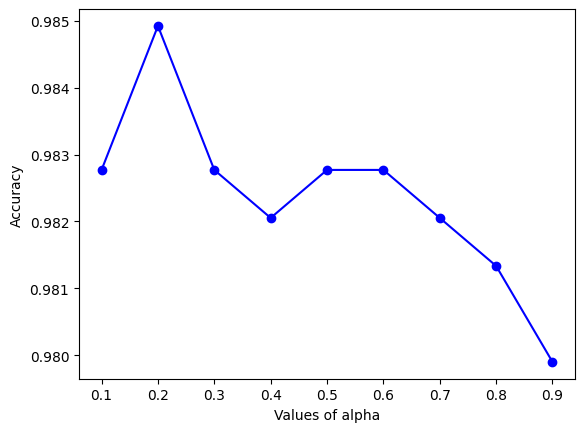

In [ ]:
alphaArr=[]
accArr=[]
maxVal=0
maxAlpha=0
for alpha in range(1,10):
    alpha*=0.1
    Y_pred=[]
    for i in range(len(X_test)):
        arr= np.where(X_test[i]!=0)[0]
        prob1 = np.log(counts[0]/(counts[0]+counts[1]))
        prob2 = np.log(counts[1]/(counts[0]+counts[1]))
        for j in arr:
            prob1 += np.log((d[0][j]+alpha)/(counts[0] + alpha*X_test.shape[1]))
            prob2 += np.log((d[1][j]+alpha)/(counts[1] + alpha*X_test.shape[1]))
        if prob1>prob2:
            Y_pred.append(0)
        else:
            Y_pred.append(1)
    alphaArr.append(alpha)
    accArr.append(accuracy_score(y_test,Y_pred))
    print("Accuracy on test data with alpha = "+str(alpha)+" : "+str(accuracy_score(y_test,Y_pred)))
    if accuracy_score(y_test,Y_pred)>maxVal:
        maxVal = accuracy_score(y_test,Y_pred)
        maxAlpha=alpha
print("Best accuracy on test is: "+str(maxVal)+" for alpha=: "+str(maxAlpha))

plt.figure()
plt.plot(alphaArr, accArr, 'bo-')
plt.xlabel('Values of alpha')
plt.ylabel('Accuracy')
plt.show()

## Comparison with Sci-kit Learn Implementation

- Use sci-kit learn's `sklearn.naive_bayes.MultinomialNB` model to compare your implementation's performance
- (Optional) try other classifiers from `sklearn.naive_bayes` and see if you can make them work`

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train,y_train)

Y_pred = model.predict(X_test)
accuracy_score(y_test,Y_pred)


0.9827709978463748

### Conclusion

The Multinomial Naive Bayes classifier was effectively applied to the Spam SMS dataset, transforming text messages into numerical count vectors using the bag-of-words representation. This method models the feature counts using a multinomial distribution, which is particularly suited for discrete data such as word frequencies in text classification tasks. By computing class priors and feature likelihoods from the training data, the model classified messages as spam or ham with measurable accuracy. Incorporating smoothing priors (Laplace smoothing) improved the handling of zero-frequency features and enhanced the model’s performance on test data. Comparisons with the scikit-learn implementation of MultinomialNB confirmed the robustness and reliability of this approach for text-based classification problems.